In [5]:
import os
print(os.getenv("POSTGRES_PASSWORD"))

dbxpassword


/tmp/ipykernel_1084/3081974585.py:98: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


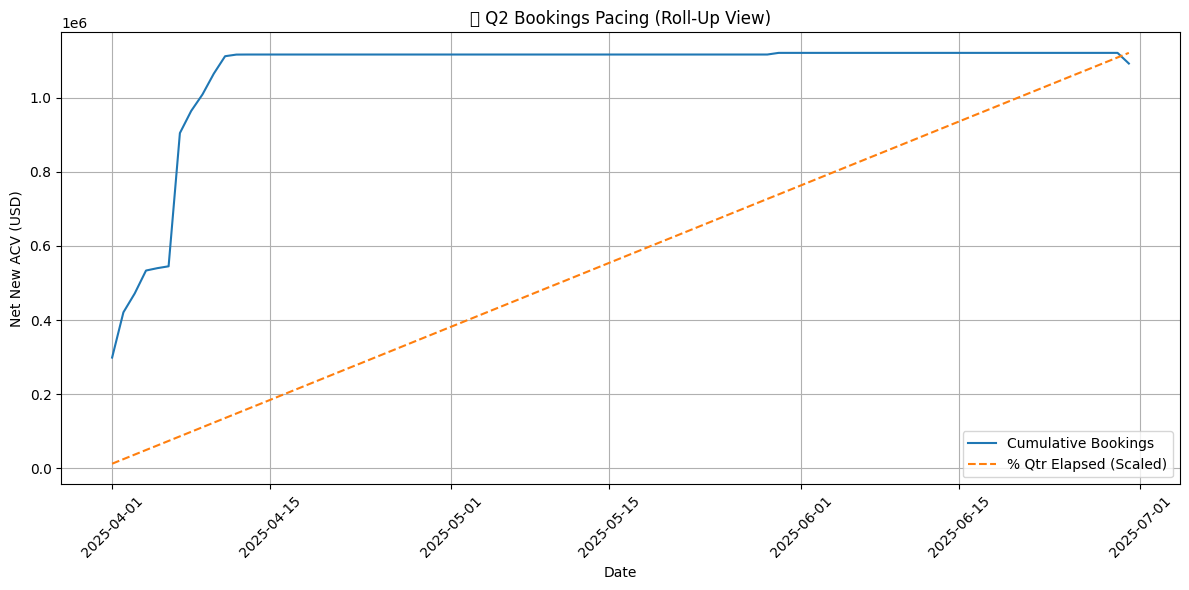

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

"""
# Create database connection
engine = create_engine(
    f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}"
    f"@{os.getenv('POSTGRES_HOST')}:{os.getenv('POSTGRES_PORT')}/{os.getenv('POSTGRES_DB')}"
)
"""
engine = create_engine("postgresql://dbx:dbxpassword@db:5432/dbx")

# SQL to get pacing view (daily + cumulative)
query = """
WITH calendar AS (
  SELECT generate_series(DATE '2025-04-01', DATE '2025-06-30', INTERVAL '1 day')::date AS calendar_day
),
q2_bookings AS (
  SELECT 
    DATE(close_date) AS close_date,
    reporting_region AS region,
    product_flag AS product,
    deal_type AS channel_type,
    net_new_acv_usd
  FROM dbx.bookings
  WHERE DATE(close_date) BETWEEN '2025-04-01' AND '2025-06-30'
),
date_dim_cross AS (
  SELECT 
    c.calendar_day,
    b.region,
    b.product,
    b.channel_type
  FROM calendar c
  CROSS JOIN (
    SELECT DISTINCT 
      reporting_region AS region,
      product_flag AS product,
      deal_type AS channel_type
    FROM dbx.bookings
    WHERE DATE(close_date) BETWEEN '2025-04-01' AND '2025-06-30'
  ) b
),
daily_bookings AS (
  SELECT 
    d.calendar_day,
    d.region,
    d.product,
    d.channel_type,
    COALESCE(SUM(b.net_new_acv_usd), 0) AS daily_acv
  FROM date_dim_cross d
  LEFT JOIN q2_bookings b
    ON DATE(b.close_date) = d.calendar_day
    AND b.region = d.region
    AND b.product = d.product
    AND b.channel_type = d.channel_type
  GROUP BY d.calendar_day, d.region, d.product, d.channel_type
),
pacing_view AS (
  SELECT 
    *,
    SUM(daily_acv) OVER (PARTITION BY region, product, channel_type ORDER BY calendar_day) AS cumulative_acv,
    ROW_NUMBER() OVER (PARTITION BY region, product, channel_type ORDER BY calendar_day) AS pacing_day,
    ROUND(ROW_NUMBER() OVER (PARTITION BY region, product, channel_type ORDER BY calendar_day)::NUMERIC / 
          COUNT(*) OVER (PARTITION BY region, product, channel_type), 4) AS pct_qtr_elapsed
  FROM daily_bookings
)
SELECT 
  calendar_day,
  SUM(daily_acv) AS daily_acv,
  SUM(cumulative_acv) AS cumulative_acv,
  MAX(pacing_day) AS pacing_day,
  MAX(pct_qtr_elapsed) AS pct_qtr_elapsed
FROM pacing_view
GROUP BY calendar_day
ORDER BY calendar_day;
"""

# Query data
df = pd.read_sql(query, engine)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="calendar_day", y="cumulative_acv", label="Cumulative Bookings")
sns.lineplot(data=df, x="calendar_day", y=(df["pct_qtr_elapsed"] * df["cumulative_acv"].max()), label="% Qtr Elapsed (Scaled)", linestyle='--')
plt.title("Q2 Bookings Pacing (Roll-Up View)")
plt.xlabel("Date")
plt.ylabel("Net New ACV (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()